In [1]:
from config.configuration import RunDetails

runDetail = RunDetails('config.yml', 'Compare-Sksmta-eval')

notebookName = 'audio-deepfake-detection-testing'

In [2]:
configFilename = runDetail.configFilename
runJobId = runDetail.jobId

In [3]:
import joblib
import numpy as np
from sklearn.metrics import confusion_matrix

import config.configuration as configuration
from preprocessors.mel_spectrogram import MelSpectrogramPreprocessor
from notebook_utils import notebookToPython
from processors.basic_model_evaluation_processor import BasicModelEvaluationProcessor
from processors.model_evaluation_result import ModelEvaluationResult
from readers.label_reader import readLabelsWithJob

In [4]:
config = configuration.ConfigLoader(configFilename)

notebookToPython(notebookName)
job = config.getJobConfig(runJobId)

import json
prettyJson = json.dumps(job.__dict__, indent=4)
print(f"job: {prettyJson}")

if (job.newModelGenerated):
    raise ValueError("This notebook is meant for testing. Select a job with a value for 'persisted-model' set.")

Write python file
Using configured model name: results/2025-04-06T21-07-25.252600_sksmta/Compare-Sksmta-training_2025-04-06T21-07-25.252600.libjob
Assigned model name: results/2025-04-06T21-07-25.252600_sksmta/Compare-Sksmta-training_2025-04-06T21-07-25.252600.libjob
job: {
    "jobId": "Compare-Sksmta-eval",
    "inputFileBatchSize": 1,
    "outputFolder": "output",
    "dataPathRootRaw": "./",
    "dataPathRoot": "./",
    "dataPathSuffix": "testaudio-sksmta",
    "dataExtension": ".flac",
    "trainingSplitRandomState": 3,
    "labelFilename": "testvalues/sksmta.train.trn.txt",
    "executeToCategoricalForLabels": true,
    "classes": [
        "spoof",
        "bonafide"
    ],
    "numClasses": 2,
    "sampleRate": 16000,
    "duration": 5,
    "numMels": 128,
    "maxTimeSteps": 109,
    "kernelSize": [
        2,
        2
    ],
    "poolSize": [
        2,
        2
    ],
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    "metrics": [
        "accuracy"
    

In [5]:
generator = MelSpectrogramPreprocessor()
model = joblib.load(job.persistedModel)
evaluationProc = BasicModelEvaluationProcessor(job, model)

MelSpectrogramPreprocessor


In [6]:
fullDataPath = job.fullJoinFilePath(job.dataPathRoot, job.dataPathSuffix)
y_test = readLabelsWithJob(job)

Loading ./testvalues/sksmta.train.trn.txt...


In [7]:
from preprocessors.abstract_preprocessor import AbstractPreprocessor
from preprocessors.preprocessor_factory import PreprocessorFactory


preproc_factory = PreprocessorFactory()
preprocessor: AbstractPreprocessor = preproc_factory.newPreprocessor(job.preprocessor)

MelSpectrogramPreprocessor


In [8]:
X_test, y_test, true_labels = preprocessor.extract_features_jobSource(job, job.dataPathSuffix)

Loading ./testvalues/sksmta.train.trn.txt...
fullDataPath: ./testaudio-sksmta
Loading audio files: 1
Loading audio files: 2
Loading audio files: 3
Loading audio files: 4
Loading audio files: 5
Loading audio files: 6
Loading audio files: 7
Loading audio files: 8
Loading audio files: 9
Loading audio files: 10
Number of audio files loaded: 10


In [9]:
results = evaluationProc.process(X_test, y_test, true_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
  Batches: 1 - Files: 10 - Score: 0.6 - Elements: 10


In [13]:
print(f'results.test: {results.test}')
print(f'results.pred: {results.pred}')
print(f'results.true: {results.true}')


results.test: [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
results.pred: [0 1 1 1 1 1 1 0 1 0]
results.true: [0 1 0 0 1 0 1 0 0 0]


confusion_matrix_plot (instance): [[3 4]
 [0 3]]


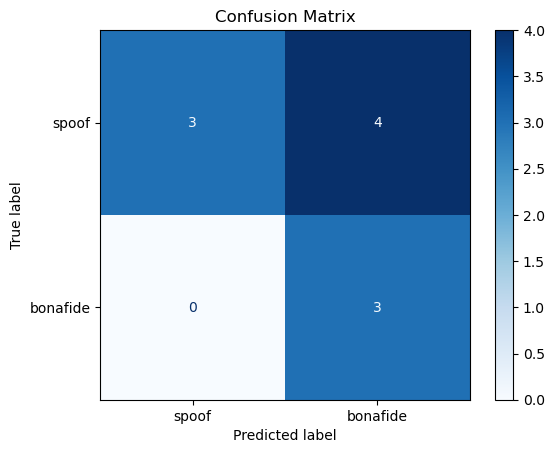

In [10]:
from postprocessors.confusion_matrix_plot import ConfusionMatrixPlot


cm_plot = ConfusionMatrixPlot()
cm_plot.plot(trueAry=results.true, predAry=results.pred, classes=job.classes)

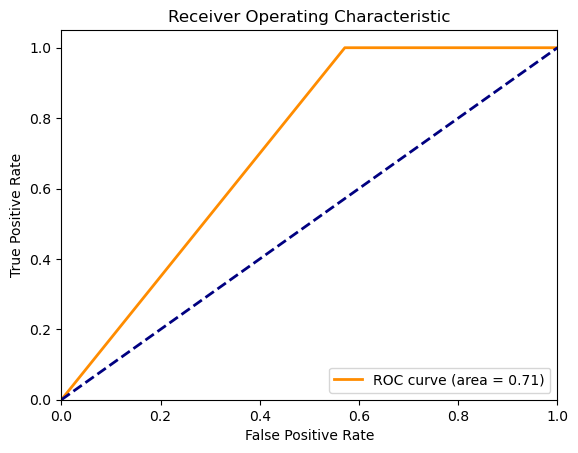

In [11]:
# Get the predicted probabilities for the positive class
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve



# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(results.true, results.pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
print("\n")
report = evaluationProc.reportSnapshot()
evaluationProc.writeReportToFile(job.persistedModelResults, report)

print(report)



---- Testing (start) ----
start time: 2025-04-07T02:13:05.074702+00:00
end time: 2025-04-07T02:13:05.740578+00:00
elapsed: 0:00:00.665876

model file: results/2025-04-06T21-07-25.252600_sksmta/Compare-Sksmta-training_2025-04-06T21-07-25.252600.libjob
batch count: 1
file count: 10
accuracy_score: 0.6

job: {
    "jobId": "Compare-Sksmta-eval",
    "inputFileBatchSize": 1,
    "outputFolder": "output",
    "dataPathRootRaw": "./",
    "dataPathRoot": "./",
    "dataPathSuffix": "testaudio-sksmta",
    "dataExtension": ".flac",
    "trainingSplitRandomState": 3,
    "labelFilename": "testvalues/sksmta.train.trn.txt",
    "executeToCategoricalForLabels": true,
    "classes": [
        "spoof",
        "bonafide"
    ],
    "numClasses": 2,
    "sampleRate": 16000,
    "duration": 5,
    "numMels": 128,
    "maxTimeSteps": 109,
    "kernelSize": [
        2,
        2
    ],
    "poolSize": [
        2,
        2
    ],
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    